In [1]:
import numpy as np

import matplotlib.pyplot as plt

from LIMxCMBL.cross_spectrum import *
from LIMxCMBL.init import *
from LIMxCMBL.noise import *
from LIMxCMBL.kernels import *

from scipy.signal.windows import dpss

from tqdm import tqdm

# CCAT-prime
zmin = 3.5
zmax = 8.1
chimin = ccl.comoving_angular_distance(cosmo, 1/(1+zmin))
chimax = ccl.comoving_angular_distance(cosmo, 1/(1+zmax))
window = np.where((chis_resample > chimin) & (chis_resample < chimax))[0]

_chimin, _chimax = chis_resample[window][0], chis_resample[window][-1]


Lambdas = np.logspace(-5, 0, 50)
Lambda = Lambdas[21]
print(Lambda)



chis_resample_len = int(np.log2(len(chis_resample)))
print(chis_resample_len)
oup_fname = '/scratch/users/delon/LIMxCMBL/eHIeHI/zmin_%.5f_zmax_%.5f_Lambda_%.5e_chi_sample_2e%d'%(zmin, zmax, Lambda,chis_resample_len)
eIeI = np.load(oup_fname + 'eIeI.npy')
eIeLO = np.load(oup_fname + 'eIeLO.npy' ,)
eLOeI = np.load(oup_fname + 'eLOeI.npy' , )
eLOeLO = np.load(oup_fname + 'eLOeLO.npy', )
eHIeHI = eIeI + eLOeLO - eIeLO - eLOeI

IHi_kappa_fname = '/scratch/users/delon/LIMxCMBL/IHiKappa/zmin_%.5f_zmax_%.5f_Lambda_%.5f_chi_sample_2e%d.npy'%(zmin, zmax, Lambda,chis_resample_len)
IHi_kappa = np.load(IHi_kappa_fname) #[kJy/sr Mpc]
IHi_kappa_windowed = IHi_kappa[:, window].astype(np.float64)

0.0013894954943731374
13


In [2]:
eHIeHI.shape

(1652, 1652)

In [3]:
chis_restricted = chis_resample[np.where((chis_resample >= chimin) & (chis_resample <= chimax))]

In [4]:
D = np.diag(chis_restricted)

d = D @ IHi_kappa_windowed.T
L = np.linalg.cholesky(D @ eHIeHI @ D)
y = np.linalg.solve(L, d)
x = np.linalg.solve(L.T, y)
res1 = np.einsum('ij, ji->i', d.T, x)

In [5]:
from scipy.interpolate import interp1d

f_d = interp1d(x = chis_restricted, y = d, axis = 0)

In [6]:
from scipy.interpolate import interp2d

In [7]:
f_eIeI = lambda chi, dchi : 1 / (dchi * chi ** 2)
f_cross = lambda chi, chip : (1/chi**2  * Lambda / np.pi * np.sinc(Lambda * (chi - chip) / np.pi)
                              + 1/chip**2 * Lambda / np.pi * np.sinc(Lambda * (chi - chip) / np.pi))


In [8]:
_chi  = chis_restricted.reshape(-1, 1)
_chip = chis_restricted.reshape(1, -1)

dchi = np.mean(np.diff(chis_restricted))
eIeI = np.diag(f_eIeI(chis_restricted, dchi))


cross = f_cross(_chi, _chip)

In [9]:
asdf_eIeLO = np.load(oup_fname + 'eIeLO.npy' ,)
asdf_eLOeI = np.load(oup_fname + 'eLOeI.npy' , )
asdf_cross = eIeLO + eLOeI

In [10]:
np.allclose(asdf_cross, cross, atol = 0.0, rtol = 1e-10)

True

In [11]:
import numba as nb

In [12]:
@nb.njit()
def integrand(_chib): 
    return Lambda**2 / np.pi**2 / _chib ** 2 * np.sinc(Lambda * (_chi - _chib) / np.pi) * np.sinc(Lambda * (_chip - _chib) / np.pi)

eLOeLO, _ = quad_vec(integrand, chimin, chimax, epsabs=0.0, epsrel=1e-3)
eHIeHI_orig = eIeI + eLOeLO - cross

In [13]:
import cProfile

In [14]:

def notjitted_integrand(_chib): 
    return Lambda**2 / np.pi**2 / _chib ** 2 * np.sinc(Lambda * (_chi - _chib) / np.pi) * np.sinc(Lambda * (_chip - _chib) / np.pi)

In [17]:
cProfile.run('quad_vec(integrand, chimin, chimax, epsabs = 0.0, epsrel = 1e-10)')

         406 function calls in 1.568 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
       63    0.128    0.002    0.128    0.002 1388378277.py:1(integrand)
        1    0.000    0.000    0.000    0.000 <frozen importlib._bootstrap>:1033(_handle_fromlist)
        1    0.006    0.006    1.568    1.568 <string>:1(<module>)
        1    0.004    0.004    1.562    1.562 _quad_vec.py:104(quad_vec)
        1    0.000    0.000    0.000    0.000 _quad_vec.py:13(__init__)
        3    0.000    0.000    0.000    0.000 _quad_vec.py:16(__setitem__)
        1    0.008    0.008    1.059    1.059 _quad_vec.py:434(_subdivide_interval)
        3    1.128    0.376    1.547    0.516 _quad_vec.py:487(_quadrature_gk)
        3    0.000    0.000    1.547    0.516 _quad_vec.py:538(_quadrature_gk21)
        1    0.000    0.000    0.000    0.000 _quad_vec.py:84(_get_sizeof)
        1    0.000    0.000    0.000    0.000 _util.py:460(__init__)
     

In [18]:
cProfile.run('quad_vec(notjitted_integrand, chimin, chimax, epsabs = 0.0, epsrel = 1e-10)')

         847 function calls in 1.525 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
       63    0.162    0.003    0.168    0.003 561786558.py:1(notjitted_integrand)
        1    0.000    0.000    0.000    0.000 <frozen importlib._bootstrap>:1033(_handle_fromlist)
        1    0.006    0.006    1.525    1.525 <string>:1(<module>)
        1    0.004    0.004    1.519    1.519 _quad_vec.py:104(quad_vec)
        1    0.000    0.000    0.000    0.000 _quad_vec.py:13(__init__)
        3    0.000    0.000    0.000    0.000 _quad_vec.py:16(__setitem__)
        1    0.005    0.005    1.010    1.010 _quad_vec.py:434(_subdivide_interval)
        3    1.052    0.351    1.507    0.502 _quad_vec.py:487(_quadrature_gk)
        3    0.000    0.000    1.507    0.502 _quad_vec.py:538(_quadrature_gk21)
        1    0.000    0.000    0.000    0.000 _quad_vec.py:84(_get_sizeof)
        1    0.000    0.000    0.000    0.000 _util.py:460(__init

In [19]:
np.allclose(eHIeHI_orig, eHIeHI, atol = 0.0, rtol = 1e-10)

True

In [26]:
chis_dense = np.linspace(np.min(chis_restricted),
                        np.max(chis_restricted),
                        2 * len(chis_restricted))
n = len(chis_dense)

_chi  = chis_dense.reshape(-1, 1)
_chip = chis_dense.reshape(1, -1)

dchi = np.mean(np.diff(chis_dense))
eIeI = np.diag(f_eIeI(chis_dense, dchi))
cross = f_cross(_chi, _chip)


@nb.jit(nopython=True)
def integrand(_chib): 
    return Lambda**2 / np.pi**2 / _chib ** 2 * np.sinc(Lambda * (_chi - _chib) / np.pi) * np.sinc(Lambda * (_chip - _chib) / np.pi)

eLOeLO, _ = quad_vec(integrand, chimin, chimax, epsabs = 0.0, epsrel = 1e-3)
eHIeHI_dense = eIeI + eLOeLO - cross

In [27]:
D = np.diag(chis_dense)
d_dense = f_d(chis_dense)
L = np.linalg.cholesky(D @ eHIeHI_dense @ D)
y = np.linalg.solve(L, d_dense)
x = np.linalg.solve(L.T, y)
res2 = np.einsum('ij, ji->i', d_dense.T, x)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


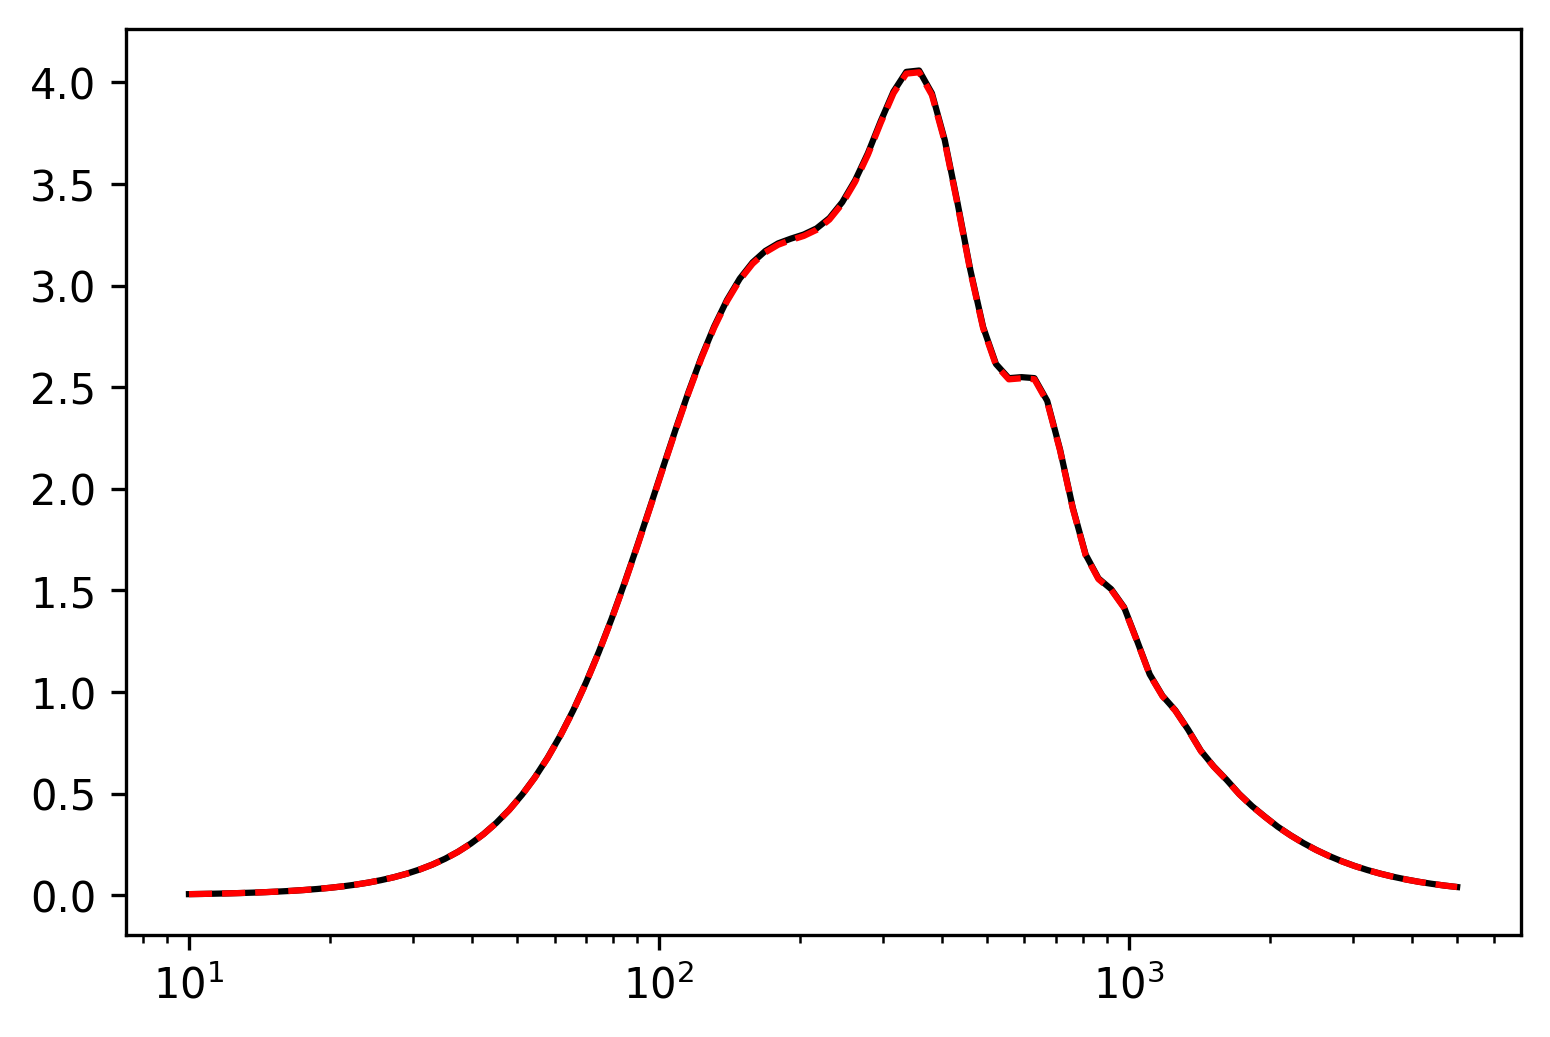

In [28]:
plt.figure(dpi = 300)
plt.plot(ells, ells**2 * res1, 'k')
plt.plot(ells, ells**2 * res2, 'r--')

plt.legend(frameon=False)
plt.xscale('log')